In [1]:
from tensorflow import keras

print(tf.__version__, ' ', tf.keras.__version__)

2.3.0   2.4.0


----

## 5.300 Using a pretrained convnet

A pretrained network is simply a network that has been trained on a large dataset - typically, a large-scale image classification task - and saved for public use

Philosophy: the pre-trained model, if it has been trained on a large and sufficiently general dataset, will have learned the spatial feature hierarchy of real-world objects (edges and corners, simple shapes, compound shapes) 

Such a pretrained model would prove useful for many different computer vision problems - even for completely different classes from those of the original task

For example, train a network on a dataset where the classes are mostly animals and everyday objects 

and apply this trained network to identifying furniture

The ability of DL models to solve new, unseen problems distinguishes DL from older, shallow learning techniques

and it makes DL very effective for small-data problems

Let's consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes)

ImageNet contains many animal classes, including different types of cats and dogs

We can expect it to perform very well on our Dog vs. Cat problem

`tensorflow.keras` has several pretrained models - they have all been trained on ImageNet :

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

We will use the VGG16 architecture

It is a simple and widely used convnet architecture for ImageNet

VGG16 is not necessarily the lightest and best pretrained model, but the architecture is similar to our previous convnets

There are two ways to deploy a pre-trained network: *feature extraction* and *fine-tuning*

We start with feature extraction

----

## 5.310 Feature extraction

Feature extraction means using the learned representations of trained networks to find relevant features in new datasets

Convnets are built in two parts:
- a *convolutional base* of pooling and conv layers 
- densely-connected classifier

The base weights and biases are 'frozen' - held fixed - and the original classifier is replaced with a new classifier that is more appropriate to the task in hand

The trained conv base extracts features; 

the new classifier is trained to interpret 

these features in terms of the new classes

Why only reuse the convolutional base? Why not use the densely-connected classifier as well? 

Because representations learned by the convolutional base are likely to be *generic*; 

those learned by the classifier are *specific* 

and *non-spatial*

Convnet feature maps represent generic concepts (edges, corners, objects etc) - concepts that will apply to many real-world images 

But representations learned by the pretrained classifier 

will be very specific to the classes 

of the original training set

Convolutional layers preserve object location; densely-connected layers lose spatial information

The loss of spatial information might be problematic for some tasks

=> disconnect pretrained classifier

The generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model 

- early, lower, layers extract local, highly generic feature (such as visual edges, colors, and textures)

- higher layers extract more abstract concepts 
- (such as 'cat ear' or 'dog eye)

- use the lower layers only, and not the entire base, for datasets that differ markedly from the original dataset of the trained model

The ImageNet class set did in fact contain multiple dog and cat classes - so it would be beneficial to reuse the the densely-connected layers of the original model 

We will chose to disconnect the top level classifier in order to demonstrate the more general case 

where the class set of the new problem 

is not a subset of the original class set

In [12]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

The constructor takes three arguments:

* `weights`, either `none`, `imagenet` or a path to a weights file  
* `include_top` for possible retention of the three layer densely-connected 1000 class classifier
* `input_shape`, shape of input image tensor

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already familiar with...

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The densely-connected classifier must accept the `(4, 4, 512)` output of the final feature map 

We have two options:

1. Extract *then* train
    - run the convolutional base over Dogs vs Cats and save output as a Numpy array
    - use the processed features as input to a standalone densely-connected classifier

Similar to training a classifier 

on a set of 4 x 4 'images' of 512 channels (!)



Extract-then-train is very fast because it only requires running the convolutional base once for every input image (the convolutional base is by far the most expensive part of the pipeline) 

But this technique would prohibit data augmentation

2. Extract *and* train
    - add `Dense` layers on top of `conv_base`
    - running the whole thing end-to-end on the input data 

Every input image is going through the convolutional base every time it is seen by the model - so we can use data augmentation

But this technique is computationally intense

Let's look at option 1 (recording the outputs of `conv_base` on our data and using these outputs as inputs to a new model)

- extract features by calling 

the `predict` method of `conv_base`
- define a dense classifier and train 

on the extracted features

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/timblackwell/Documents/Goldsmiths/2021/Data Science/data/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [9]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
Found 1000 images belonging to 2 classes.
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
Found 1000 images belonging to 2 classes.
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


The extracted features are currently of shape `(samples, 4, 4, 512)`

Flatten to `(samples, 8192)` ready for input to a dense classifier

In [10]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Define the densely-connected classifier (with dropout for regularisation)

and train it on the recorded data and labels:

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 15ms/step - loss: 0.5896 - acc: 0.6765 - val_loss: 0.4369 - val_acc: 0.8350
Epoch 2/30
100/100 [==============================] - 1s 12ms/step - loss: 0.4219 - acc: 0.8110 - val_loss: 0.3619 - val_acc: 0.8570
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3516 - acc: 0.8435 - val_loss: 0.3189 - val_acc: 0.8850
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3140 - acc: 0.8705 - val_loss: 0.2978 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2855 - acc: 0.8865 - val_loss: 0.2858 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 1s 13ms/step - loss: 0.2592 - acc: 0.9010 - val_loss: 0.2809 - val_acc: 0.8760
Epoch 7/30
100/100 [==============================] - 1s 13ms/step - loss: 0.2381 - acc: 0.9110 - val_loss: 0.2630 - val_acc: 0.8980
Epoch 8/30
100/100 [==============================] - 1s 12ms/step - 

Training is very fast, less than 1 sec/epoch, since there are only two `Dense` layers

Inspect training loss and accuracy:

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

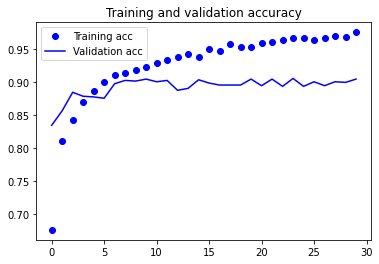

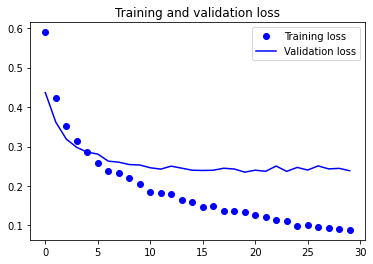

In [12]:
plt.show()

We attain about 90% validation accuracy

Much better than our small model trained from scratch

But the plots also indicate overfitting despite 50% d.o.

Generator driven data augmentation is impossible with option 1

and data augmentation is essential for preventing overfitting with small image datasets

So let's now consider Option 2 (extract and train)

- add a classifier to the `conv_base` model
- train the entire model on the 

data-augmented inputs 

This technique is very expensive (about 5 mins/epoch on a cpu) - you should consider using a GPU, or even a TPU

GPU and TPU runtimes are available at 

Google Colaboratory

`tensorflow.keras` presents a common interface for models and layers - models can be clicked into place as if they were layers

Simple add `conv_base` to a `Sequential` model:

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


14.7 million parameters in the convolutional base and 2 million dense classifier parameters

Pretty big!

It would be disastrous to go ahead 

and train the model

The `Dense` layers on top are randomly initialized; very large weight updates would be propagated through the network, effectively destroying the previously learned representations of the conv base

Solution: 'freeze' the convolutional base 

A layer is 'frozen' if its weights cannot be updated during training 

Model or layer `trainable` attribute to `False`

Freezing must take place before compilation

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

In [15]:
print('Trainable parameter tensors before freezing the conv base:', len(model.trainable_weights))

Trainable parameter tensors before freezing the conv base: 30


In [16]:
conv_base.trainable = False

In [17]:
print('Trainable parameter tensors after freezing the conv base:', len(model.trainable_weights))

Trainable parameter tensors after freezing the conv base: 4


VGG16 has 13 conv layers and each layer has a main weight tensor ($w$) and a bias tensor ($b$)

The dense classifier has two trainable layers - that's four more tensors of trainable parameters

30 tensors of trainable parameters before freezing

4 tensors after freezing

Training the model with data augmented input:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 274s - loss: 0.5804 - acc: 0.7150 - val_loss: 0.4457 - val_acc: 0.8250
Epoch 2/30
100/100 - 303s - loss: 0.4691 - acc: 0.7940 - val_loss: 0.3538 - val_acc: 0.8660
Epoch 3/30
100/100 - 305s - loss: 0.4280 - acc: 0.8035 - val_loss: 0.3203 - val_acc: 0.8870
Epoch 4/30
100/100 - 325s - loss: 0.3954 - acc: 0.8195 - val_loss: 0.2996 - val_acc: 0.8910
Epoch 5/30
100/100 - 329s - loss: 0.3862 - acc: 0.8250 - val_loss: 0.2902 - val_acc: 0.8750
Epoch 6/30
100/100 - 309s - loss: 0.3694 - acc: 0.8295 - val_loss: 0.2808 - val_acc: 0.8820
Epoch 7/30
100/100 - 307s - loss: 0.3472 - acc: 0.8470 - val_loss: 0.2673 - val_acc: 0.8900
Epoch 8/30
100/100 - 346s - loss: 0.3529 - acc: 0.8455 - val_loss: 0.2603 - val_acc: 0.8930
Epoch 9/30
100/100 - 309s - loss: 0.3425 - acc: 0.8495 - val_loss: 0.2650 - val_acc: 0.8930
Epoch 10/30
100/100 - 326s - loss: 0.3394 - acc: 0.8470 - val_loss: 0.2615 - val_acc: 0.

In [20]:
model.save('cats_and_dogs_small_3.h5')

Inspect training:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

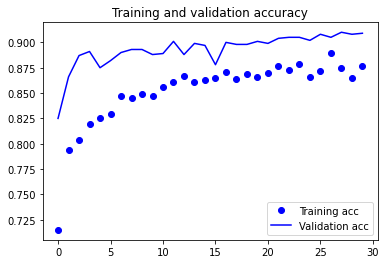

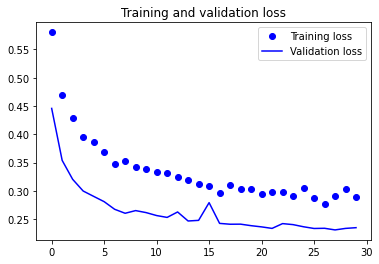

In [21]:
plt.show()

No overfitting - data augmentation has worked

We reach a validation accuracy of about 90%, about the same as option 1 (extract, then train) and again better than the small convnet trained from scratch

But there is a final trick up the pretrained sleeve

----

## 5.320 Fine-tuning

Another widely used technique: unfreezing a few of the top layers of a frozen model base 

'Fine-tuning' adjusts the more abstract representations of the pretrained model in order to make them more relevant for the problem at hand

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

It is only possible to fine-tune the top layers of the convolutional base *once the classifier on 
top has already been trained* 

Otherwise the error signal propagating back through the network would be too large and the representations previously learned by the unfrozen conv layers would be destroyed 

Steps for fine-tuning a network:

1. Add the custom network on top of the pretrained base
2. Freeze the base
3. Train the custom network
4. Unfreeze some base layers
5. Jointly train these layers and the custom network

We have already completed the first 3 steps

Let's proceed with step 4. 

Fine-tune the last 3 convolutional layers

All layers up to `block4_pool` will be frozen

`block5_conv1`, `block5_conv2` and `block5_conv3` will be trainable:

In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Why not fine-tune more layers? 

Why not fine-tune the entire convolutional base? 

But consider:

Earlier conv base layers encode generic features whilst higher layers encode more specialized features

It is more useful to fine-tune the more specialized features - the generic festures (edges, corners, colours etc) are expected to be present in any real-world image

The convolutional base has 14.7M parameters - a huge model with a very real chance of overfitting

Another reason not to fine tune the entire base

Freeze all but block 5 layers: 

In [23]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

We should limit the magnitude of modifications to the representations of the unfrozen layers

Use a tiny learning rate - large updates may damage these representations

Let's go:

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 340s 3s/step - loss: 0.2832 - acc: 0.8750 - val_loss: 0.2493 - val_acc: 0.8890
Epoch 2/30
100/100 [==============================] - 332s 3s/step - loss: 0.2403 - acc: 0.9030 - val_loss: 0.2037 - val_acc: 0.9150
Epoch 3/30
100/100 [==============================] - 325s 3s/step - loss: 0.2344 - acc: 0.9015 - val_loss: 0.1845 - val_acc: 0.9200
Epoch 4/30
100/100 [==============================] - 329s 3s/step - loss: 0.2072 - acc: 0.9110 - val_loss: 0.2185 - val_acc: 0.9100
Epoch 5/30
100/100 [==============================] - 346s 3s/step - loss: 0.2124 - acc: 0.9100 - val_loss: 0.1933 - val_acc: 0.9270
Epoch 6/30
100/100 [==============================] - 342s 3s/step - loss: 0.2034 - acc: 0.9130 - val_loss: 0.1858 - val_acc: 0.9260
Epoch 7/30
100/100 [==============================] - 357s 4s/step - loss: 0.1785 - acc: 0.9300 - val_loss: 0.1816 - val_acc: 0.9270
Epoch 8/30
100/100 [==============================] - 338s 3s/step - 

In [26]:
model.save('cats_and_dogs_small_4.h5')

Inspect results:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

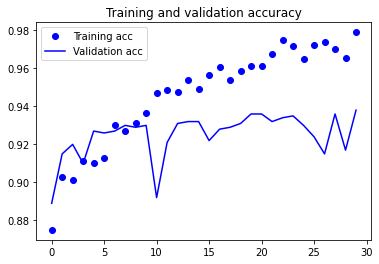

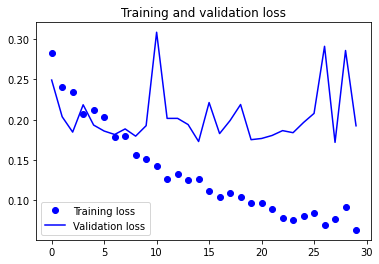

In [27]:
plt.show()

The curves are very noisy

Smooth by replacing with exponential moving averages:

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

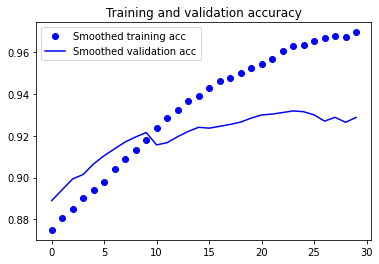

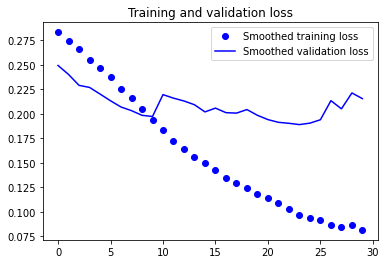

In [28]:
plt.show()

The curves are smoother and more stable

Accuracy has improved by 2 or 3%

You might find in your experiments that the average loss increases whilst accuracy improves

Accuracy depends on the distribution of values and not the average 

labels (0, 0, 0, 1, 1, 1)

output (0.0, 0.0, 0.6, 0.4, 0.0, 0.0): acc =  67%, loss (MSE) = $\frac{2 \times 0.36}{6} = 0.12$

output (0.4, 0.4, 0.4, 0.6, 0.6, 0.6): acc = 100%, loss (MSE) = $0.4^2 = 0.16$

Accuracy has improved (67% to 100%) but loss has worsened (0.12 to 0.16)

Finally evaluate this model on the test data (ideally we should retrain on the merger of the training and the validation sets):

In [30]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 89s 2s/step - loss: 0.2155 - acc: 0.9300
test acc: 0.9300000071525574


----

## 5.330 Wrapping-up

- Convnets are the first-choice machine learning models for computer vision tasks
- Overfitting on small datasets can be ameliorated by data augmentation 
- Pretrained feature extraction is another possible technique for small CV datasets
- Fine-tune upper pretrained layers for even better performance


----

MIT Licence
 
Copyright (c) 2017-present François Chollet
 
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
 
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
 
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.